<a href="https://colab.research.google.com/github/nidhaloff/Regression-Pytorch/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [235]:
import keras
from keras import backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

%matplotlib inline

# run keras model on google GPU
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [236]:
dataset = make_regression(n_samples=1000, n_features=1, noise=5, random_state=42)
X, y = dataset
X.shape, y.shape

((1000, 1), (1000,))

In [237]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [238]:
pip install skorch

In [0]:
import skorch
from skorch import NeuralNet

(1000, 1) (1000, 1)
torch.Size([800, 1]) torch.Size([800, 1])
Epoch: 0 => average training loss= 238.1662879356971 average test losses= 131.1465187072754 and accuracy= 0.5286490733955806
Epoch: 1 => average training loss= 159.09632462721603 average test losses= 82.36730718612671 and accuracy= 0.7028009592676103
Epoch: 2 => average training loss= 114.90947874998434 average test losses= 64.58732398351033 and accuracy= 0.7614411792643377
Epoch: 3 => average training loss= 92.57847929000854 average test losses= 56.01393926143646 and accuracy= 0.7888784165824498
Epoch: 4 => average training loss= 79.07633452782264 average test losses= 50.40033197402954 and accuracy= 0.8076970737858746
Epoch: 5 => average training loss= 69.87528214087853 average test losses= 46.503366549809776 and accuracy= 0.8212350879792369
Epoch: 6 => average training loss= 63.32293537684849 average test losses= 43.70440462657383 and accuracy= 0.8310076497734957
Epoch: 7 => average training loss= 58.42027108485882 average

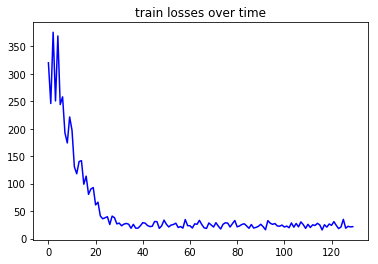

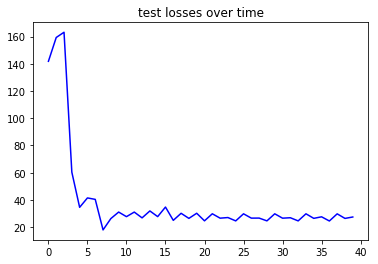

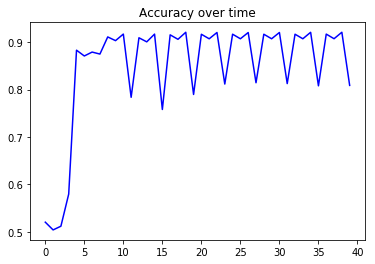

final train loss value =  21.676368713378906
final test loss value =  27.449270248413086
final accuracy of the model =>  0.8087522191800498


In [240]:
# implementation only using pytorch

y = y.reshape(-1, 1)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train_torch = torch.from_numpy(X_train.astype(np.float32))
y_train_torch = torch.from_numpy(y_train.astype(np.float32))
X_test_torch = torch.from_numpy(X_test.astype(np.float32))
y_test_torch = torch.from_numpy(y_test.astype(np.float32))
print(X_train_torch.shape, y_train_torch.shape)


trainset = TensorDataset(X_train_torch, y_train_torch)
testset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)


class Regressor(nn.Module):
    def __init__(self, n_features, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 100)
        self.fc2 = nn.Linear(100, n_out)
#         self.fc3 = nn.Linear(600, 300)
#         self.fc4 = nn.Linear(300, n_out)
        
    def forward(self, x):
        out = self.fc1(x)
#         out = F.tanh(self.fc2(out))
#         out = F.sigmoid(self.fc3(out))
        out = self.fc2(out)
        return out
    

model = Regressor(X.shape[1], 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

def training_func(model, criterion, optimizer):
    def train_step(sample, target):
        model.train()
        optimizer.zero_grad()
        out = model(sample)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        return loss.item()
    return train_step

def fit(epochs=10):
    train_losses, test_losses, accuracy_list = ([] for _ in range(3))
    train = training_func(model=model, criterion=criterion, optimizer=optimizer)
    for e in range(epochs):
        for x, y in train_loader:
            loss_val = train(x, y)
            train_losses.append(loss_val)
            
        else:
            with torch.no_grad():
                model.eval()
                for x_test, y_test in test_loader:
                    pred = model(x_test)
                    loss = criterion(pred, y_test)
                    test_losses.append(loss.item())
                    accuracy = r2_score(y_test.numpy(), pred.numpy())
                    accuracy_list.append(accuracy)
                    
        print(f"Epoch: {e} => average training loss= {sum(train_losses)/ len(train_losses)} average test losses= {sum(test_losses)/ len(test_losses)} and accuracy= {sum(accuracy_list)/ len(accuracy_list)}")
        
    return train_losses, test_losses, accuracy_list
                    

def plot_results(train_losses, test_losses, accs):
    plt.plot(train_losses, color="b")
    plt.title("train losses over time")
    plt.show()
    plt.plot(test_losses, color= "b")
    plt.title("test losses over time")
    plt.show()
    
    plt.plot(accs, color= "b")
    plt.title("Accuracy over time")
    plt.show()
    

train_losses, test_losses, accs = fit(10)
plot_results(train_losses, test_losses, accs)
print("final train loss value = ", train_losses[-1])
print("final test loss value = ", test_losses[-1])
print("final accuracy of the model => ", accs[-1])


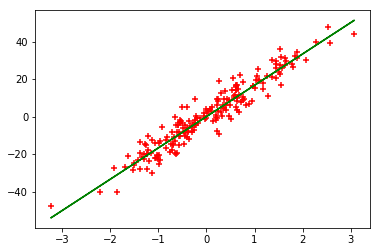

In [241]:
# see the results
preds = model(X_test_torch)
plt.scatter(X_test, y_test, c="r", marker="+")
plt.plot(X_test, preds.detach().numpy(), color="g")